# Data Analyst Ocado Internship Task
## Mateusz Marczyk
## Python, SQL
## 07.04.2024, Kraków

In [734]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [735]:
def extract_table_data(file, table_name):
    data = []
    reading_data = False
    line_number = 0  
    with open(file, "r") as f:
        for line in f:
            line_number += 1  
            try:
                if line.startswith("INSERT INTO {} ".format(table_name)):
                    reading_data = True
                    continue
                elif line.startswith("INSERT INTO"):
                    reading_data = False
                if reading_data:
                    line = line[1:-3].strip()
                    seg = line.split(",")
                    data.append(seg)
            except IndexError:
                print(f"Error occurred at line {line_number}: {line}") 
    return data

In [736]:
file_name = "droptime.sql"

table_names = ["products", "orders", "orders_products", "route_segments"]

dfs = {}
for table_name in table_names:
    data = extract_table_data(file_name, table_name)
    columns = ["product_id", "weight"] if table_name == "products" else \
              ["order_id", "customer_id", "sector_id", "planned_delivery_duration"] if table_name == "orders" else \
              ["order_id", "product_id", "quantity"] if table_name == "orders_products" else \
              ["segment_id", "driver_id", "segment_type", "order_id", "segment_start_time", "segment_end_time"]
    dfs[table_name] = pd.DataFrame(data, columns=columns)
    
    

products_df = dfs["products"]
orders_df = dfs["orders"]
orders_products_df = dfs["orders_products"]
route_segments_df = dfs["route_segments"]
route_segments_df['order_id'] = route_segments_df['order_id'].str.strip()

products_df['product_id'] = products_df['product_id'].astype(int)
products_df['weight'] = pd.to_numeric(products_df['weight'])

orders_df['order_id'] = orders_df['order_id'].astype(int)
orders_df['customer_id'] = orders_df['customer_id'].astype(int)
orders_df['sector_id'] = orders_df['sector_id'].astype(int)
orders_df['planned_delivery_duration'] = pd.to_numeric(orders_df['planned_delivery_duration'])

orders_products_df['product_id'].fillna(-1, inplace=True)

orders_products_df['product_id'] = orders_products_df['product_id'].astype(int)

orders_products_df['product_id'] = orders_products_df['product_id'].astype(int)
orders_products_df['quantity'] = pd.to_numeric(orders_products_df['quantity'])

route_segments_df['segment_id'] = route_segments_df['segment_id'].astype(int)
route_segments_df['driver_id'] = route_segments_df['driver_id'].astype(int)

route_segments_df['order_id'] = pd.to_numeric(route_segments_df['order_id'], errors='coerce')

route_segments_df['segment_start_time'] = pd.to_datetime(route_segments_df['segment_start_time'])
route_segments_df['segment_end_time'] = pd.to_datetime(route_segments_df['segment_end_time'])

# Part 2. Data analysis and visualisation

## 1. Generate a histogram showing the actual delivery time with 1 minute granularity (rounded up).

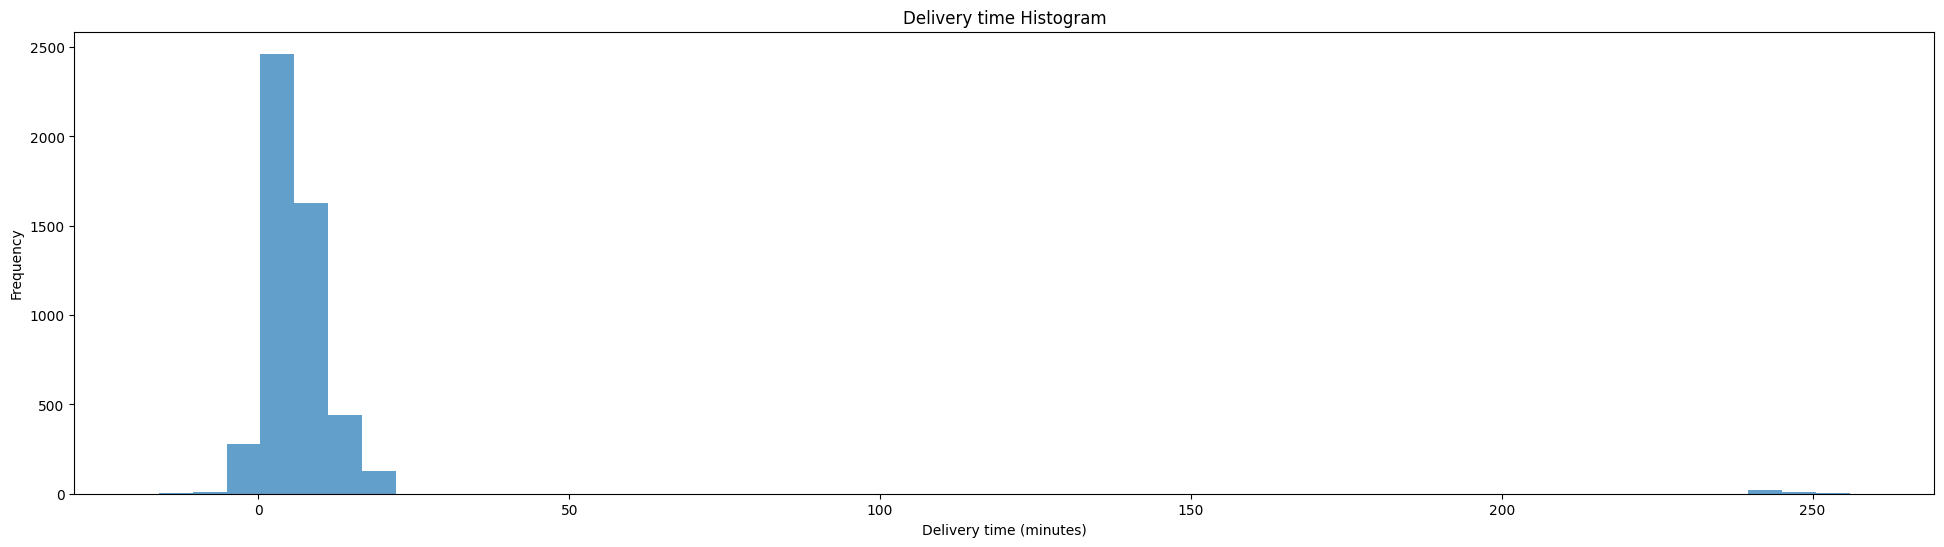

In [737]:
route_segments_df.loc[:, 'delivery_time_seconds'] = (route_segments_df['segment_end_time'] - route_segments_df['segment_start_time']).dt.total_seconds()

route_segments_df.loc[:, 'delivery_time_minutes'] = route_segments_df['delivery_time_seconds'] / 60

route_segments_df.loc[:, 'delivery_time_rounded'] = np.ceil(route_segments_df['delivery_time_minutes'])

plt.figure(figsize=(24, 6))
plt.hist(route_segments_df['delivery_time_rounded'], bins=50, alpha=0.7)
plt.xlabel('Delivery time (minutes)')
plt.ylabel('Frequency')
plt.title('Delivery time Histogram')
plt.show()

### as we can see from the histogram, the majority of the delivery times are definitely less than 100 minutes. Let's check the exact values distribution.

In [738]:
print(route_segments_df['delivery_time_rounded'].value_counts().sort_index(ascending=True))

delivery_time_rounded
-16.0       3
-14.0       1
-11.0       1
-10.0       1
-9.0        2
-8.0        1
-7.0        3
-6.0        5
-5.0        1
-4.0        4
-3.0        1
-2.0        5
-1.0        2
 0.0      263
 1.0      202
 2.0      547
 3.0      688
 4.0      584
 5.0      442
 6.0      352
 7.0      268
 8.0      251
 9.0      254
 10.0     235
 11.0     269
 12.0     273
 13.0      52
 14.0      40
 15.0      35
 16.0      43
 17.0      48
 18.0      39
 19.0      26
 20.0      12
 241.0      3
 242.0      8
 243.0      6
 244.0      3
 245.0      3
 246.0      2
 247.0      1
 248.0      4
 249.0      1
 250.0      2
 251.0      1
 252.0      2
 253.0      1
 256.0      1
Name: count, dtype: int64


### as we can see from the distribution, the majority of the delivery times are in range of 0 to 20 minutes. Let's generate a histogram for this range.

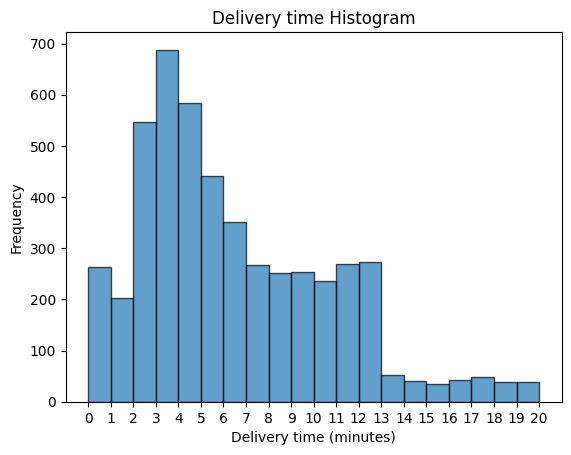

In [739]:
plt.hist(route_segments_df['delivery_time_rounded'], edgecolor='black', bins=range(0, 21), alpha=0.7)
plt.xticks(range(21))
plt.xlabel('Delivery time (minutes)')
plt.ylabel('Frequency')
plt.title('Delivery time Histogram')
plt.show()

### Let's also take a look at delivery times for STOP segments where order_id is not null.

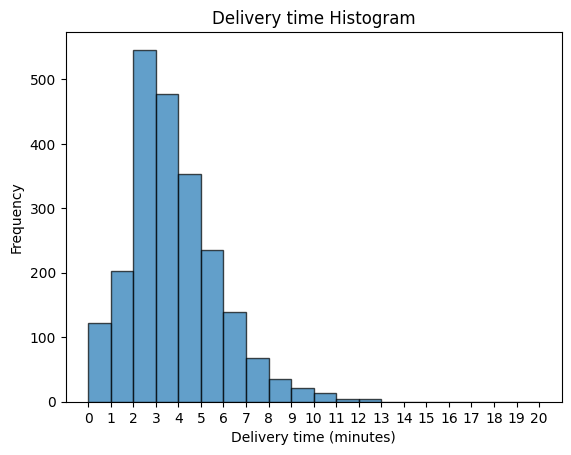

In [740]:
merged_df = pd.merge(route_segments_df, orders_df, on='order_id')
plt.hist(merged_df['delivery_time_rounded'], edgecolor='black', bins=range(0, 21), alpha=0.7)
plt.xticks(range(21))
plt.xlabel('Delivery time (minutes)')
plt.ylabel('Frequency')
plt.title('Delivery time Histogram')
plt.show()

### as we can see from the histogram, when it comes to STOP segments, the majority of the delivery times are between 0 and 7 minutes

## 2. Generate a histogram showing prediction error (difference between planned and actual delivery times).

In [741]:
# I will need the copy for later analysis
merged_df_copy = merged_df.copy()

In [742]:
merged_df['difference'] = abs(merged_df['planned_delivery_duration'].astype(int) - merged_df['delivery_time_seconds'].astype(int))

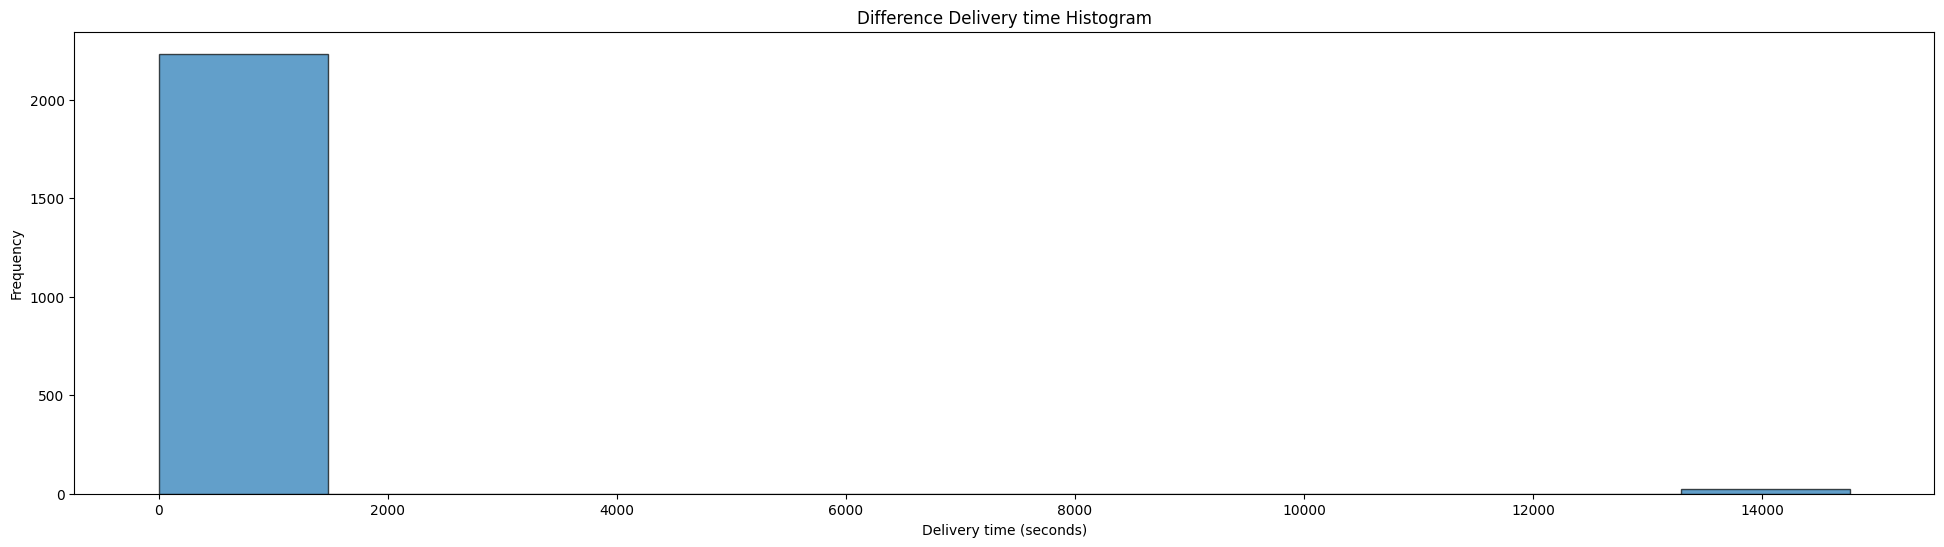

In [743]:
plt.figure(figsize=(24, 6))
plt.hist(merged_df['difference'], edgecolor='black', alpha=0.7)
plt.xlabel('Delivery time (seconds)')
plt.ylabel('Frequency')
plt.title('Difference Delivery time Histogram')
plt.show()

### similarly as earlier as we can see from the histogram, the majority of the delivery times are definitely less than 20000 minutes. Let's check the exact values distribution.

In [744]:
print(merged_df['difference'].value_counts().sort_index(ascending=True).to_string())


difference
0        11
1        19
2         9
3        14
4        17
5        17
6        12
7        12
8        11
9         5
10        9
11       14
12       11
13       13
14        9
15       15
16       25
17       12
18       16
19       12
20        5
21       19
22       10
23       19
24       18
25       16
26       10
27       15
28       14
29       14
30       20
31       14
32       13
33       11
34       17
35       19
36       17
37       15
38       14
39       16
40       12
41       18
42       13
43       16
44       12
45       12
46       15
47       22
48        8
49       16
50       13
51       13
52       11
53        6
54       12
55       13
56       24
57        9
58       11
59       14
60       18
61       15
62        9
63       19
64       12
65       14
66       14
67       11
68       11
69       13
70        8
71        7
72       15
73       22
74       12
75       12
76       14
77       12
78        9
79       14
80       14
81       12
82   

### as we can see from the distribution, the majority of the delivery times are in range of 0 to 514 seconds. Let's generate a histogram for this range.

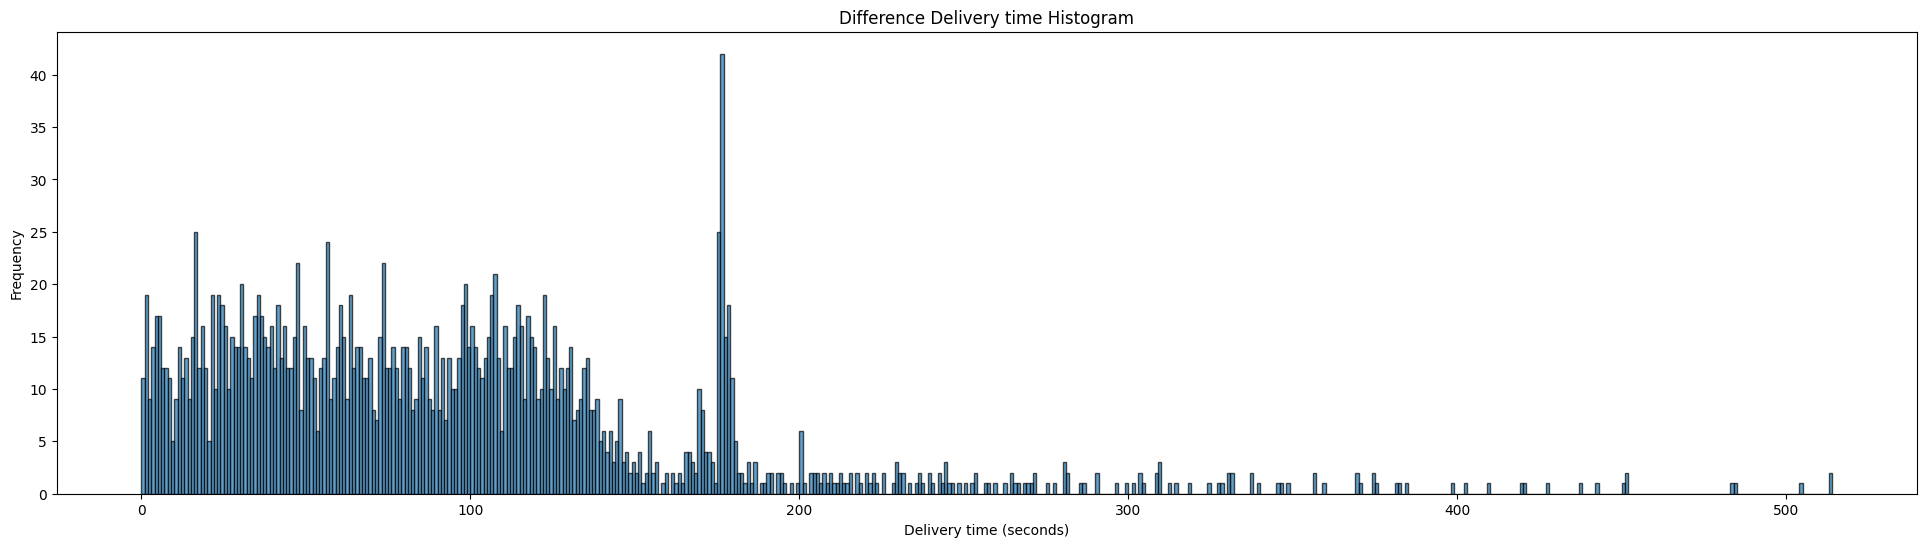

In [745]:
plt.figure(figsize=(24, 6))
plt.hist(merged_df['difference'], edgecolor='black', bins=range(0, 515), alpha=0.7)
plt.xlabel('Delivery time (seconds)')
plt.ylabel('Frequency')
plt.title('Difference Delivery time Histogram')
plt.show()


### Let's take a closer look and generate a histogram for the range of 0 to 200 seconds.

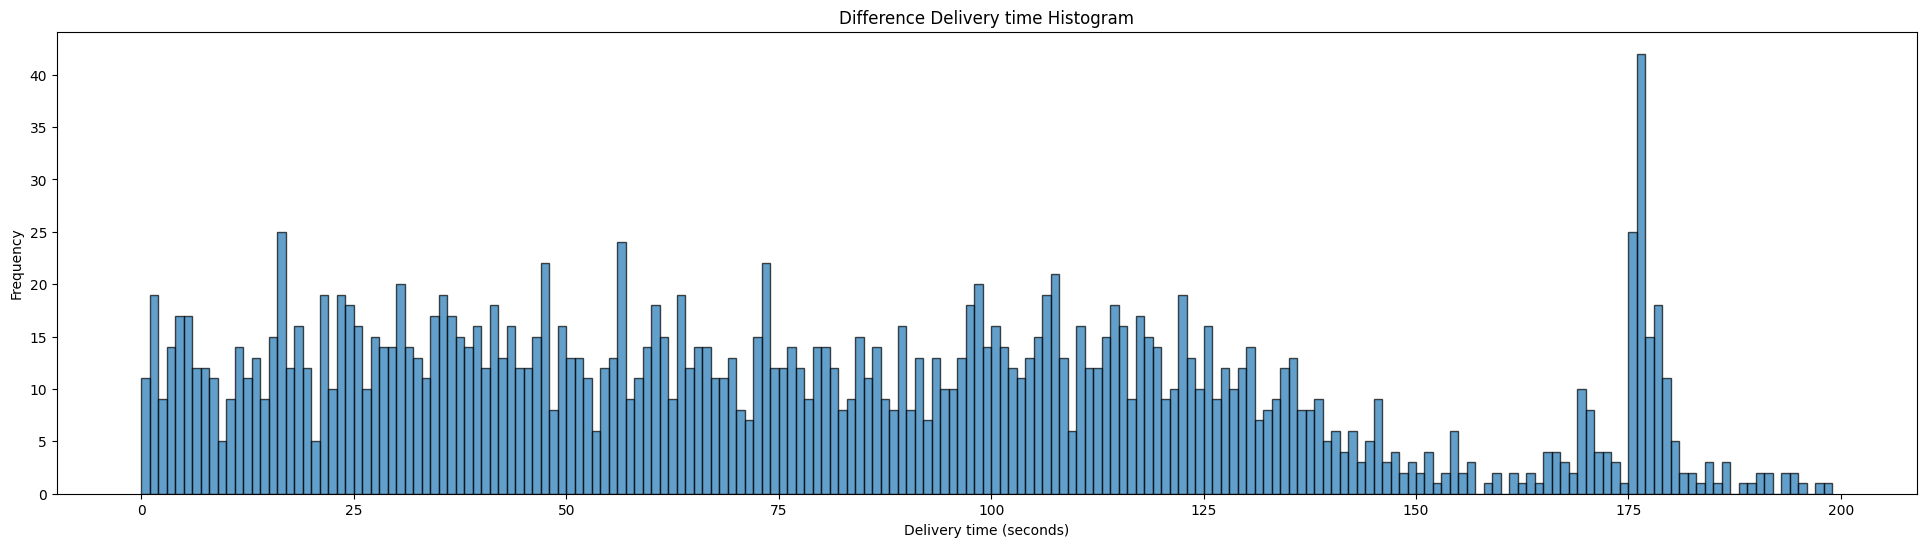

In [746]:
plt.figure(figsize=(24, 6))
plt.hist(merged_df['difference'], edgecolor='black', bins=range(0, 200), alpha=0.7)
plt.xlabel('Delivery time (seconds)')
plt.ylabel('Frequency')
plt.title('Difference Delivery time Histogram')
plt.show()

## 3. We received insight from our drivers that delivering in one of the sectors is significantly longer than in other sectors. Generate a chart to visualise this hypothesis.

### First let's take a look at the statistics for delivery times by sector.

In [747]:
statistics_delivery_time = merged_df.groupby('sector_id')['delivery_time_minutes'].describe()
statistics_delivery_time

,count,mean,std,min,25%,50%,75%,max
sector_id,,,,,,,,
1,739.0,5.661254,21.841322,-5.050000,1.816667,3.450000,5.208333,249.050000
2,739.0,5.282161,26.371447,-4.416667,1.266667,2.233333,3.300000,244.866667
3,779.0,5.149487,25.656463,-4.550000,1.183333,2.250000,3.416667,245.783333


### As we can see, sector 1 has the longest delivery time on average. Let's generate a chart to visualize this.

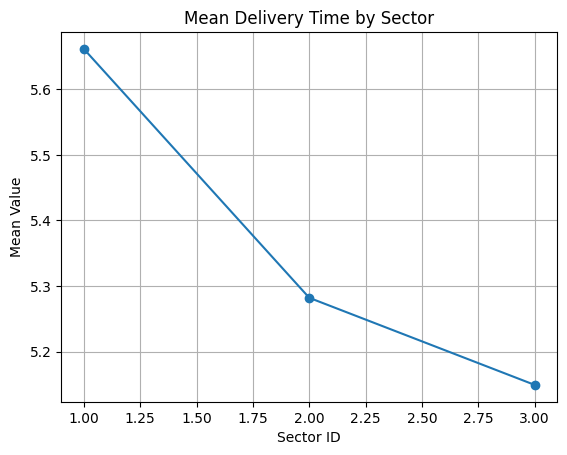

In [748]:
import matplotlib.pyplot as plt

mean_delivery_time = merged_df.groupby('sector_id')['delivery_time_minutes'].mean()

plt.plot(mean_delivery_time, marker='o', linestyle='-')

plt.xlabel('Sector ID')
plt.ylabel('Mean Value')
plt.title('Mean Delivery Time by Sector')

plt.grid(True)
plt.show()

### As we can see in the chart, sector with ID 1 has the longest delivery time. However, I would not say that the difference between the average times in these 3 sectors is very different. The statistics also seem to confirm this.

## 4. Play with the data by grouping, aggregating and remodelling it. Are you able to find any correlations or trends that could be valuable for prediction quality improvement? Describe briefly your findings and visualise them on charts.

### Let's take a look at the maximum delivery time for each sector. Maybe there is a sector where the maximum delivery times are significantly longer than in other sectors.

In [749]:
merged_df.groupby('sector_id')['delivery_time_minutes'].max()

sector_id
1    249.050000
2    244.866667
3    245.783333
Name: delivery_time_minutes, dtype: float64

In [750]:
sorted_df = merged_df.sort_values(by='delivery_time_minutes', ascending=False)
selected_columns = sorted_df[['sector_id', 'delivery_time_minutes']]
selected_columns

,sector_id,delivery_time_minutes
1452,1,249.050000
295,1,247.650000
798,3,245.783333
1756,1,245.633333
423,2,244.866667
...,...,...
62,3,-3.450000
304,2,-4.333333
1300,2,-4.416667
1658,3,-4.550000


### As we can see, the maximum delivery times are not significantly different between sectors. The distribution of delivery times is similar for all sectors. Perhaps it is error in the dataset, and they are just outliers.

### Maybe just couple customers are causing the longer delivery times. If yes, they should have low standard deviation of delivery times.

In [751]:
merged_df.groupby('customer_id').agg(
    mean_delivery_duration=('delivery_time_seconds', 'mean'),
    std_delivery_duration=('delivery_time_seconds', 'std'),
    sector_id=('sector_id', 'first')
).sort_values(by='mean_delivery_duration', ascending=False)


,mean_delivery_duration,std_delivery_duration,sector_id
customer_id,,,
293,7376.500000,10106.677223,1
97,5932.600000,7899.066768,2
48,3802.500000,7246.651296,3
142,2524.833333,5850.590719,1
66,2519.333333,5886.005289,1
...,...,...,...
244,69.000000,71.084457,3
150,55.600000,36.637413,2
73,50.200000,165.561771,3


### It is not the case. The standard deviation is very high for all customers, with high delivery times.

### Perhaps it's the high weight of the products that causes the longer delivery times. Let's check it out!

In [752]:
orders_products_df = orders_products_df[orders_products_df['order_id'] != '']
route_segments_df = route_segments_df.dropna(subset=['order_id'])

route_segments_df.loc[:, 'order_id'] = route_segments_df['order_id'].astype(int)
route_segments_df['order_id'] = route_segments_df['order_id'].astype(int)
orders_products_df['order_id'] = orders_products_df['order_id'].astype(int)
merged_df = pd.merge(merged_df, orders_products_df, on='order_id', how='inner')
merged_df = pd.merge(merged_df, products_df, on='product_id', how='inner')
merged_df['total_weight'] = merged_df['weight'] * merged_df['quantity']

order_summary = merged_df.groupby('order_id').agg({'total_weight': 'sum', 'delivery_time_minutes': 'first'}).reset_index()

order_summary_sorted = order_summary.sort_values(by='total_weight', ascending=False)
order_summary_sorted.head(30)

C:\Users\user\AppData\Local\Temp\ipykernel_10884\1911056540.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  route_segments_df['order_id'] = route_segments_df['order_id'].astype(int)
C:\Users\user\AppData\Local\Temp\ipykernel_10884\1911056540.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orders_products_df['order_id'] = orders_products_df['order_id'].astype(int)


,order_id,total_weight,delivery_time_minutes
513,513.0,26388.0,4.883333
788,788.0,24248.0,2.600000
756,756.0,23633.0,1.783333
1901,1901.0,23443.0,2.383333
1896,1896.0,23244.0,3.883333
502,502.0,22390.0,4.883333
1783,1783.0,22245.0,11.033333
1084,1084.0,21056.0,4.833333
294,294.0,20239.0,9.583333
1853,1853.0,20167.0,1.733333


### As we can see the total weight of the products does not seem to have a significant impact on the delivery time.

# Part 3. Building and verifying the hypothesis

## The current prediction algorithm is very naive. It calculates the mean from all collected data and applies it to every future order. We need to explore alternative ideas. One of them is predicting delivery times per sector. Describe how you would validate this hypothesis using available data.

### First I would split into independent sets based on sectors and then analyze the delivery times for each sector, look at the statistics, visualize data for better understanding. I would try to look for significant differences and based on that validate the hypothesis.

## Using the data, propose some alternative method/algorithm that will predict delivery times more accurately. Describe the methodology to validate the new algorithm.

### Let's create machine learning model to predict delivery times. We will merged_df from previous analysis as it contains all necessary data.

### First let's prepare data by grouping it by order_id and calculating total weight of the products, then preserving only necessary columns.

In [753]:
merged_df['total_weight'] = merged_df['weight'] * merged_df['quantity']

grouped_df = merged_df.groupby('order_id').agg({
    'driver_id': 'first',
    'segment_start_time': 'first',
    'segment_end_time': 'first',
    'delivery_time_seconds': 'first',
    'sector_id': 'first',
    'total_weight': 'sum'
}).reset_index()
grouped_df.drop(columns=['order_id'], inplace=True)

In [754]:
print(grouped_df.dtypes)
grouped_df['delivery_time_seconds'] = grouped_df['delivery_time_seconds'].astype(int)
grouped_df.drop(columns=['segment_start_time', 'segment_end_time'], inplace=True)

driver_id                         int32
segment_start_time       datetime64[ns]
segment_end_time         datetime64[ns]
delivery_time_seconds           float64
sector_id                         int32
total_weight                    float64
dtype: object


In [755]:
grouped_df2 = grouped_df.copy()

In [756]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

y = grouped_df.pop('delivery_time_seconds')
X = grouped_df

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)

rf_regressor.fit(X_train, y_train)

y_pred = rf_regressor.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)  
print("Mean Absolute Error:", mae)  


Mean Absolute Error: 328.0816325467687


### The Mean Absolute Error is quite high. Let's try to improve the model by removing outliers.

In [757]:
grouped_df = grouped_df2[grouped_df2['delivery_time_seconds'] <= 1000]

y = grouped_df.pop('delivery_time_seconds')
X = grouped_df

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)

rf_regressor.fit(X_train, y_train)

y_pred = rf_regressor.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)  
print("Mean Absolute Error:", mae)  


Mean Absolute Error: 48.33822415272415


### As we can see the Mean Absolute Error is much lower now, nearly 7 times. It probably means that the outliers are errors in dataset. Let's see if gradient boosting regressor can improve the model even more.

In [758]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error
gb_regressor = GradientBoostingRegressor(random_state=42)

gb_regressor.fit(X_train, y_train)

y_pred = gb_regressor.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error:", mae)

Mean Absolute Error: 38.796674702122765


### The Mean Absolute Error is even lower. MAE dropped almost 20%, which is a significant improvement. Let's try to tune the hyperparameters to improve the model even more.

In [759]:
gb_regressor = GradientBoostingRegressor(random_state=42)

param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=gb_regressor, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print("Best Parameters:", best_params)

best_gb_regressor = GradientBoostingRegressor(**best_params, random_state=42)

best_gb_regressor.fit(X_train, y_train)

y_pred = best_gb_regressor.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error:", mae)

Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Mean Absolute Error: 38.234091441642384


### Hyperparameter tuning improved the model just a bit. So finally we get MAE at 38. Let's compare it with the current MAE, using average as prediction.

### First let's calculate the MAE for the current model with outliers.

In [760]:
mae = mean_absolute_error(merged_df_copy['delivery_time_seconds'], merged_df_copy['planned_delivery_duration'])
print("Mean Absolute Error:", mae)

Mean Absolute Error: 245.39610101905183


### As we can see the MAE for the current model is more than 6 times higher than the MAE for the model with outliers removed. Let's see what is the MAE without outliers.

In [761]:
merged_df_copy = merged_df_copy[merged_df_copy['delivery_time_seconds'] <= 1000]
mae = mean_absolute_error(merged_df_copy['delivery_time_seconds'], merged_df_copy['planned_delivery_duration'])
print("Mean Absolute Error:", mae)

Mean Absolute Error: 93.27989252127183


### The MAE for the current model without outliers is still more twice higher than the MAE for the model with outliers removed. Out machine learning model improved the predictions very well.

### To sum thing up, I think that the best way to predict delivery times is to use machine learning models. Even with the dataset I used, which is very limited, I was able to improve the predictions significantly. I think that with more data and more features (which I will describe later), the model could be improved even more. I would also consider using more complex models, like neural networks, to improve the predictions even more.

## Why could some deliveries take more time? For example, some buildings don’t have elevators etc. Describe your ideas.

### I would point out a few factors that could affect the delivery time:
- Location Accessibility: some locations may be more difficult to access than others, which could increase delivery times
- Building Features: elevators, stairs, gated communities
- Traffic: traffic jams, roadworks
- Weather: rain, snow, storms
- Incorrect or Incomplete Address: driver may have trouble finding the location
- Technical Issues: vehicle breakdown, GPS issues

## What additional data would be worth collecting for future analysis of this domain?

### I would consider collecting the following additional data:
- Traffic Data: traffic congestion, road closures, accidents
- Vehicle Data: vehicle type, age, maintenance
- Driver Data: experience, performance, working hours
- Route Data: distance, elevation, road type
- Building Data: features, accessibility, security

### I would also improve the partitioning algorithm for the GPS, so the whole road that driver took is clear